# Manual for omics data filtering using PhenoFeatureFinder
## loading the data

You will load your data as an object of the OmicsAnalysis class, so you can apply the funtions of this class to your data. Therefore, you will need to give the object a name to which you will refer when using these functions. In this example, I will call my object 'example'. To specify the name of your data file and where to find it, you enter the path to your data at 'metabolome_csv=' as done in the example. Next, you specify the name of the column with the feature IDs at 'metabolome_feature_id_col='.

Make sure your data is in a .csv format, uses '_' instead of ' ' (so no spaces), and is in lower case (so no capitals). The first column of your data should contain the feature IDs (so the identifier of the feature) and the other columns should be the samples (including the blanks if applicable). The values in the dataframe should be positive or zero. So the top of your dataset should look something like this:

| feature_id    | blank_1   | blank_2   | sample_1  | sample_2  | sample_3  | sample_4  |
|---------------|-----------|-----------|-----------|-----------|-----------|-----------|
| feature_1     | 0         | 0         | 5698      | 981       | 6784      | 2345      |
| feature_2     | 0         | 234       | 789       | 34        | 356       | 12        |

First load the OmicsAnalysis class. If your working with PhenoFeatureFinder as a downloaded package, use:

In [ ]:
#import numpy as np

from phenofeaturefinder.omics_analysis import OmicsAnalysis


If your working with PhenoFeatureFinder as a local github clone, use:

In [1]:
import sys
sys.path.append('../../src/PhenoFeatureFinder/')

from omics_analysis import OmicsAnalysis

Then load your data as object of the OmicsAnalysis class:

In [2]:
example = OmicsAnalysis(
    metabolome_csv="./data_for_manuals/metabolome_example_data.csv",
    metabolome_feature_id_col="feature_id")

Next, we need to check if the input dataframe indeed doesn't have negative values:

In [3]:
example.validate_input_metabolome_df()

Metabolome input data validated.


Now, if we run the line below, we can have a look at the number of features in the dataset before we start the filtering steps. This shows you that the example dataset has 11059 features.

In [4]:
print("Number of total features before blank filtering = {0}".format(example.metabolome.shape[0]))

Number of total features before blank filtering = 11059


## Filtering features

There are several filtering options.

### Filtering based on blanks

The first is to remove all features that are present in the blanks. This is a recomended step, because these features are most likely background noise or components from the sample collection buffer.

There is only one parameter in this function:
* blank_sample_contains: string, default='blank' <br> Column names containing this will be considered blank samples.
            
The sample IDs of the blanks in the example data are called 'blank_1', 'blank_2', 'blank_3' and 'blank_4', so we will use the default 'blank' to identify the blank features.

In [5]:
example.discard_features_detected_in_blanks(blank_sample_contains="blank")

When we run the line below, we can that we have 7544 features left after the filtering based on the blanks:

In [6]:

print("number of total features after blank filtering = {0}".format(example.metabolome.shape[0]))

number of total features after blank filtering = 7544


### Density plots per group

To get an idea of the distribution of your data, you can visualise it with density plots. This could help you make a decision on the filtering steps you want to use.

This function creates a histogram for each group with a density plot (darker blue line) plotted over it.

The parameter for this function is:

* nbins: integer, default=1000 <br> The number of bins used to create the plot. A higher number of bins increases the precision, but also drastically slows down the calculations for the plotting.


<Figure size 640x480 with 0 Axes>

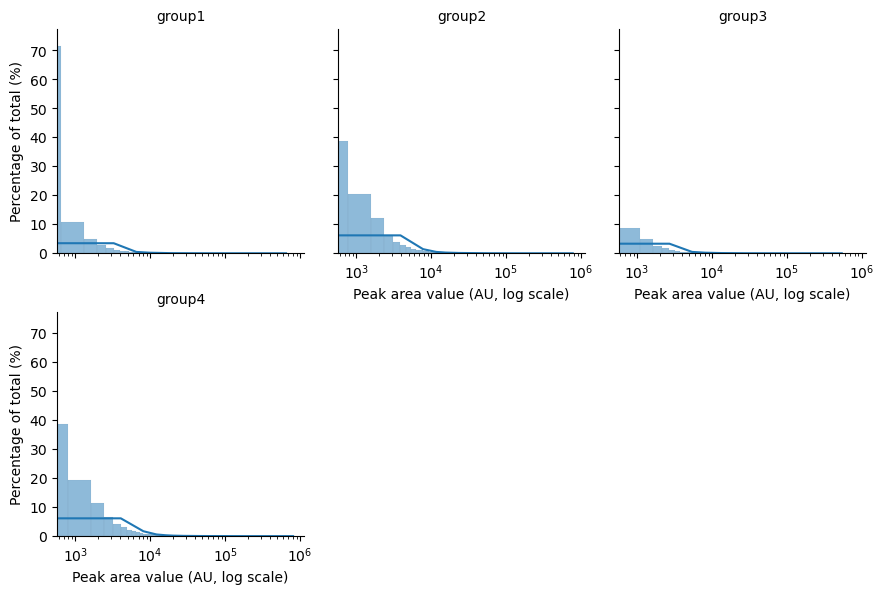

In [7]:
example.create_density_plot(nbins=1000)

In the plot, you can see that over 70% of the features has a small value in group1, while group3 has much less features with a small value and therefore likely has more features with a high value.

### Filter features by percentile

An optional filtering step is the filtering by percentile. With this step, only the most abundant features per genotype will remain. For example, selecting the 95 <sup>th</sup> percentile will discard the 95% of features with the lowest values. This selection is made per group, after which the selections are combined and all selected features are kept.

By removing the features with a low abundance, a large part of the background noise is likely to be removed. This can therefore be a useful filtering step when you (expect to) have noisy data. The drawback of this filtering step is that interesting features do not necessarily always have a high abundance. When you expect your feature(s) of interest to have a low abundance (for example when interested in intermediates of a metabolic pathway), it is not recommended to use is filtering step.

The parameter for this function:

* percentile: float, default=50 <br> The percentile threshold, can be a value between 0 and 100.

In the density plots, we could see that especially group1 has a large amount of features with a low abundance. We expect this dataset to have a lot of background noise, because the samples were collected in a greenhouse, a relatively dirty environment compared to lab settings.
For the example, let's therefore select the 75 <sup>th</sup> percentile:

In [8]:
example.filter_features_per_group_by_percentile(percentile=75)

After this filtering step, we've got 5287 features left:

In [9]:
print("number of features after feature filtering by percentile= {0}".format(example.metabolome.shape[0]))

number of features after feature filtering by percentile= 5287


### Filter unreliable features

Another option is to filter out the unreliable features. This means that you remove all features that are not present in at least n replicates of at least 1 group. You could argue that a feature that is very important for a phenotype, should be present in all (or at least most) of the replicates from a group that shows this phenotype.

The parameter for this function is:

* nb_times_detected: integer, default=4 <br> Number of times a feature should be detected to be considered 'reliable'. Should be equal to or lower than the number of replicates.

in the example data, each group has 4 replicates so we set 'nb_times_detected' to 4.

In [10]:
example.filter_out_unreliable_features(nb_times_detected=4)

Our dataset now has 4637 features:

In [11]:
print("numberof total features after unreliable feature filtering = {0}".format(example.metabolome.shape[0]))

numberof total features after unreliable feature filtering = 4637


## saving the filtered data
If you are happy with the filtered data, you can save it as a .csv file.

In [12]:
example.write_clean_metabolome_to_csv(path_of_cleaned_csv="./cleaned_metabolite_example_data.csv")

## data visualization

After finishing the filtering steps, it's nice to get a better feeling for the structure of your data. 

Two insightfull visualization options for large datasets such as these are a Principle Component Analysis and an UpSet plot. For both these options we have integrated a function in this package.

### PCA

For the PCA we start by computing the principle components.

The parameters for this function are:

* scale: boolean, default=True <br> Perform scaling, set the feature values to zero mean and unit variance. Applies sklearn.preprocessing.StandardScaler(with_mean=True, with_std=True).
* n_principal_components: integer, default=10 <br> Number of principal components to keep in the PCA analysis. If the number of PCs > min(n_samples, n_features) then set to the minimum of (n_samples, n_features)

For the example, we'll use the dafault settings:

In [13]:
example.compute_pca_on_metabolites(n_principal_components=10)

To check if you computed the Principle Components:

In [14]:
example.pca_performed

True

We can now create a scree plot to see how much of the variance each Principle Component explains:

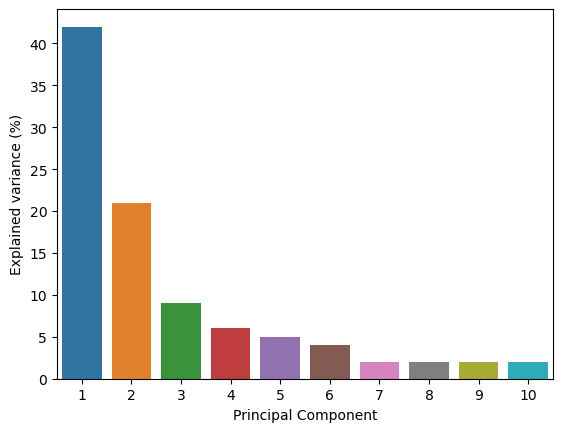

In [15]:
example.create_scree_plot()

The scree plot shows that the first Principle Component explains over 40% of the variance and second over 20%.

If you want to check whether is using the features as features and the samples as samples you can use the line below. This outputs the shape as the PCA as (number of samples, number of PCs), so for the example this is (16, 10).
If the features were used as if it were the samples, the output would be (4637, 10).

In [16]:
example.metabolome_pca_reduced.shape

(16, 10)

Now that we know that we accuratly computed the PCA, we can create the sample score plot and have a look at the grouping.

The parameters for this function are:

* pc_x_axis: integer, default=1 <br> Principal Component to plot on the x-axis (default is 1 so PC1 will be plotted).
* pc_y_axis: integer, default=2 <br> Principal Component to plot on the y-axis (default is 2 so PC2 will be plotted).
* name_grouping_var: string, default="genotype" <br> Name of the variable used to color samples. 
* show_color_legend: boolean, default=True <br> Add a legend to the figure.
* plot_file_name: string, default=None <br> A file name and its path to save the sample score plot. <br> For instance "mydir/sample_score_plot.pdf" <br> The path is relative to current working directory.

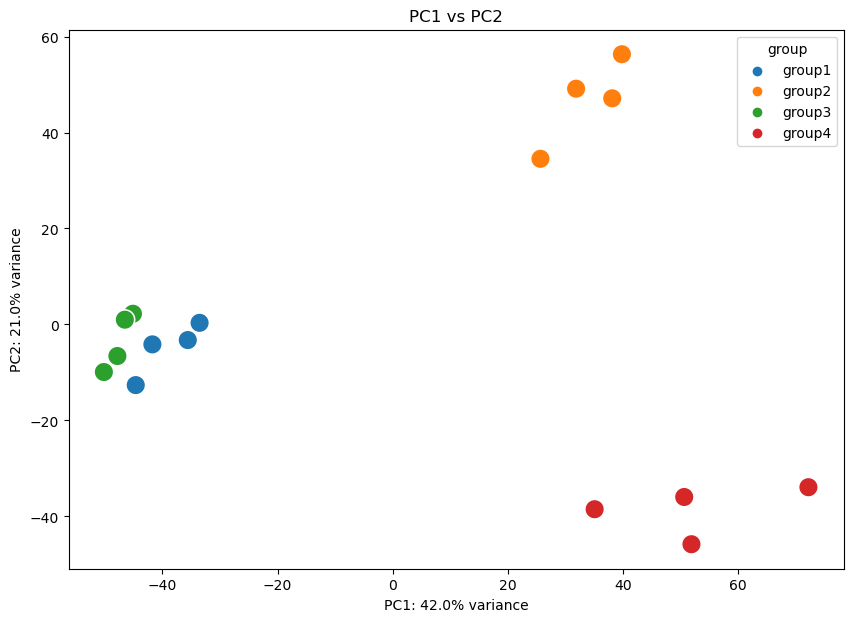

In [17]:
example.create_sample_score_plot(
    pc_x_axis=1,
    pc_y_axis=2,
    name_grouping_var='group',
    show_color_legend=True,
    plot_file_name=None)

### UpSet plot

If you want to get some insight into how many features are common amongst all or some of the groups, you can make an UpSet plot.

The current version of this function transforms your data, so be carefull if you use it before saving the filtered data or finishing the filtering steps.

The parameter for this function is:

* plot_file_name: string, default=None <br> A file name and its path to save the sample score plot. <br> For instance "mydir/sample_score_plot.pdf" <br> The path is relative to current working directory.

In the UpSet plot for the example data you can see for example that 19 features are only present in group2 and 38 features are only present in group4, while 728 features are present in group2 and group4, but not in the other two.

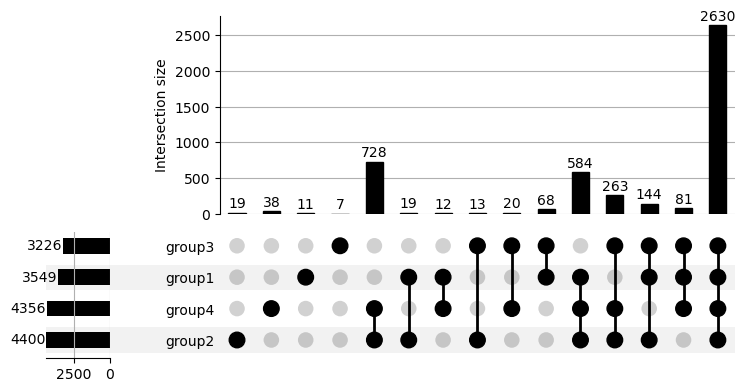

In [18]:
example.plot_features_in_upset_plot(plot_file_name=None)